In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
from scipy.optimize import curve_fit
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)
#print("scipy.optimize version", scipy.optimize.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
vector.register_awkward() 

In [3]:
SAMPLE_RUNS = sorted([290323, 290327, 290848, 291361, 291360, 291362, 290853, 290860, 291373, 290374, 290375, 291399,
               291400, 290894, 290895, 290404, 291943, 291944, 291948, 291953, 290932, 290423, 291447, 290935, 
               290425, 290427, 291451, 291453, 291976, 291982, 290456, 290458, 290459, 291482, 291485, 290975, 
               290980, 290469, 292012, 291002, 291003, 291004, 291005, 290501, 292040, 292060, 292061, 292062, 
               291041, 290539, 290540, 292075, 292077, 292080, 290549, 290553, 291590, 292106, 292108, 292109, 
               292115, 290590, 291618, 291622, 291624, 292140, 290612, 292160, 292162, 292163, 292164, 292166, 
               290632, 291657, 292168, 292192, 290658, 290660, 291690, 291692, 291694, 291698, 291706, 290687, 
               290692, 290696, 290699, 292242, 292265, 291755, 292269, 292270, 291760, 292273, 292274, 290742, 
               291769, 291263, 290764, 290766, 291283, 291284, 291285, 291795, 291796, 290776, 291803, 290787])
print(len(SAMPLE_RUNS))

108


In [26]:
def integral(histo: hist.Hist, start: float, stop: float):
    start_bin = histo.axes[0].index(start)  
    stop_bin = histo.axes[0].index(stop)
    return histo[start_bin:stop_bin].sum()

def getTracksData(events):
    return ak.zip({
        "px"      : events["Muon_Px"],
        "py"      : events["Muon_Py"],
        "pz"      : events["Muon_Pz"],
        "E"       : events["Muon_E"],
        "charge"  : events["Muon_Charge"],
        "thetaAbs": events["Muon_thetaAbs"],
        "matched" : events["Muon_matchedTrgThreshold"]},
        with_name='Momentum4D')

def Momentum4D(events):
    return ak.zip({
        "px": events["0"].px + events["1"].px,
        "py": events["0"].py + events["1"].py,
        "pz": events["0"].pz + events["1"].pz,
        "E" : events["0"].E  + events["1"].E},
        with_name="Momentum4D")

def scan(dataDescription, 
         hMagData:hist.Hist, hPhiData:hist.Hist, hEtaData:hist.Hist, hYData:hist.Hist, hPtData:hist.Hist, hMassData:hist.Hist, hMass_OSData:hist.Hist, hMass_LSData:hist.Hist,
         eventSelectorData = lambda x:[True]*len(x),
         trackSelectorData = lambda x:[True]*len(x), 
         verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    nEntries = nGoodEvents = nGoodTracks = nGoodEntries = nPairs = nOS = nLS = 0
    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT", "isCMUL", "isCMSL", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge", 
                                 "Muon_thetaAbs", "Muon_matchedTrgThreshold"],                                
                                report = True):
        
        
        events = batch[0] # batch[1] is the report info
        
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
        
        
        goodEvents = events[eventSelectorData(events)]
        tracks = getTracksData(goodEvents)
        goodTracks = tracks[trackSelectorData(tracks)]
        
        
        pairs = ak.combinations(goodTracks, 2)
        
        condition_OS = np.logical_or(np.logical_and(pairs["0"].charge ==  1, pairs["1"].charge == -1),
                                     np.logical_and(pairs["0"].charge == -1, pairs["1"].charge ==  1))
        pairs_OS = pairs[condition_OS]
        OS = Momentum4D(pairs_OS)
    
        
        condition_LS = np.logical_or(np.logical_and(pairs["0"].charge == -1, pairs["1"].charge == -1),
                                     np.logical_and(pairs["0"].charge ==  1, pairs["1"].charge ==  1))
        pairs_LS = pairs[condition_LS]
        LS = Momentum4D(pairs_LS)

        
        hMagData.fill(ak.flatten(goodTracks.p))
        hPhiData.fill(ak.flatten(goodTracks.phi))
        hPtData.fill(ak.flatten(goodTracks.pt))
        hYData.fill(ak.flatten(goodTracks.rapidity))
        hEtaData.fill(ak.flatten(goodTracks.eta))
        hMassData.fill(ak.flatten(goodTracks.mass))
        
        hMass_OSData.fill(ak.flatten(OS.mass))
        hMass_LSData.fill(ak.flatten(LS.mass))

        
        nEntries += len(events)
        nGoodEvents += len(goodEvents)
        nGoodTracks += len(ak.flatten(goodTracks))
        nGoodEntries += list(ak.num(goodTracks) > 0).count(True)
        nPairs += len(ak.flatten(pairs))
        nOS += len(ak.flatten(OS))
        nLS += len(ak.flatten(LS))

        if verbose:
            print(batch[1])
            print("Entries: ", nEntries)
            print("Good Events: ", nGoodEvents)
            print("Good Tracks: ", nGoodTracks)
            print("Good Entries: ", nGoodEntries)
            print("Pairs: ", nPairs)
            print("OS: ", nOS)
            print("LS: ", nLS)
            print("---------------------------------------------------------------------------------------")
        gc.collect()
        
    return nEntries, nGoodEvents, nGoodTracks, nGoodEntries, nPairs, nOS, nLS

In [27]:
%%time

hMag= hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhi = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
hEta = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hY = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hPt = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMass = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))

hMass_OS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

Entries = goodEvents = goodTracks = goodEntries = Pairs = OS = LS = 0

for run in SAMPLE_RUNS:
    a, b, c, d, e, f, g = scan(dataDescription = f"/pbs/throng/training/nantes-m2-rps-exp/data/run{run}.data.root:eventsTree",
                              hMagData = hMag, hPhiData = hPhi, hEtaData = hEta, hYData = hY, hPtData = hPt, hMassData = hMass, hMass_OSData = hMass_OS, hMass_LSData = hMass_LS,
                              eventSelectorData = lambda x: x["isCMUL"] == True, 
                              trackSelectorData = lambda x: (x.theta < 10) & (x.theta > 2) & (x.pt > 0.5) & (x.eta < -2.5) & (x.eta > -4),
                              verbose = True)
    Entries += a
    goodEvents += b
    goodTracks += c
    goodEntries += d
    Pairs += e
    OS += f
    LS += g

print("Entries: ", Entries)
print("Good Events: ", goodEvents)
print("Good Tracks: ", goodTracks)
print("Good Entries: ", goodEntries)
print("Pairs: ", Pairs)
print("OS: ", OS)
print("LS: ", LS)

<Report start=0 stop=2139140 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.data.root:/eventsTree;1'>
Entries:  2139140
Good Events:  410205
Good Tracks:  290018
Good Entries:  232245
Pairs:  61115
OS:  51985
LS:  9130
---------------------------------------------------------------------------------------
<Report start=0 stop=190395 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290327.data.root:/eventsTree;1'>
Entries:  190395
Good Events:  36880
Good Tracks:  25798
Good Entries:  20708
Pairs:  5398
OS:  4608
LS:  790
---------------------------------------------------------------------------------------
<Report start=0 stop=1109829 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290374.data.root:/eventsTree;1'>
Entries:  1109829
Good Events:  213125
Good Tracks:  150547
Good Entries:  120518
Pairs:  31723
OS:  27009
LS:  4714
---------------------------------------------------------------------------------------
<Report start=0 stop=446234 source='/pbs/t

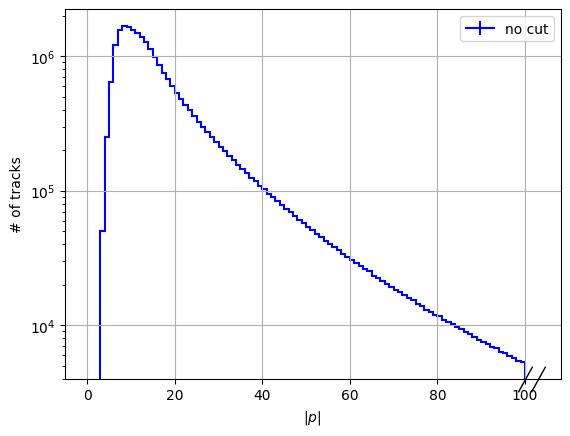

In [36]:
hMag.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

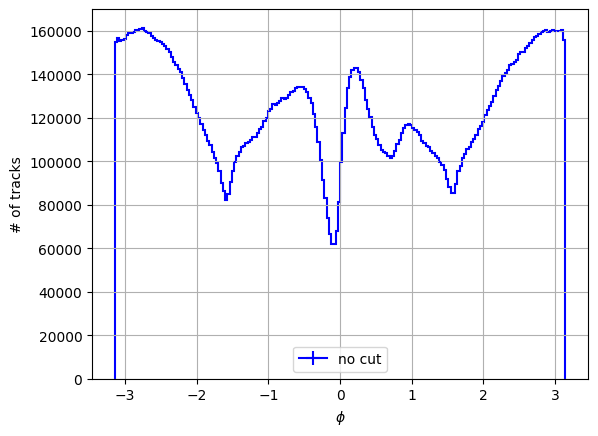

In [37]:
hPhi.plot(color = "blue", label = "no cut")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

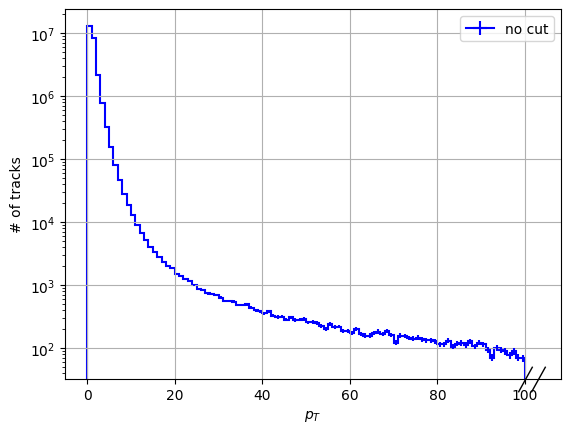

In [38]:
hPt.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

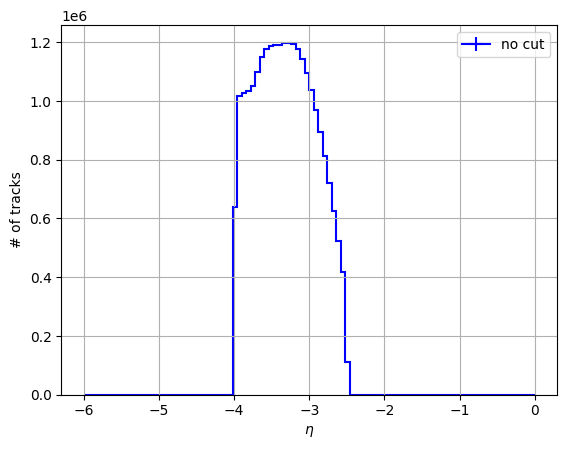

In [39]:
hEta.plot(color = "blue", label = "no cut")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

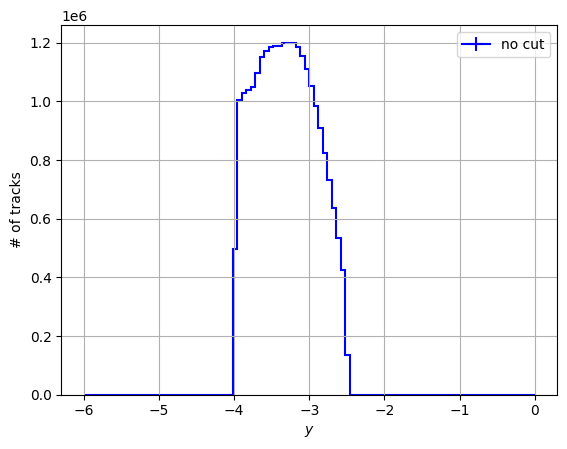

In [40]:
hY.plot(color = "blue", label = "no cut")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

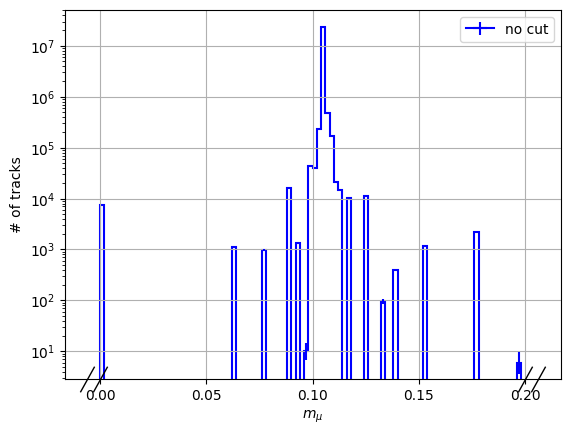

In [41]:
hMass.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

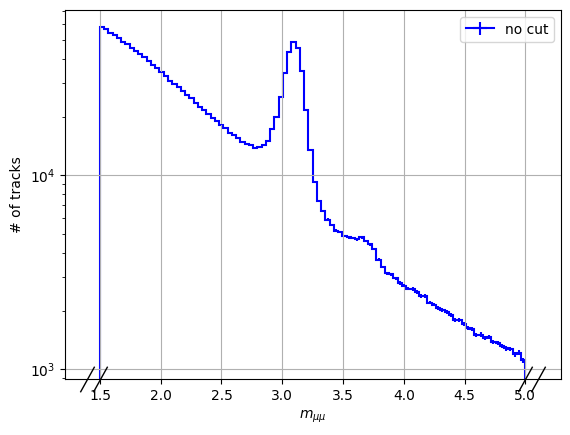

In [42]:
hMass_OS.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

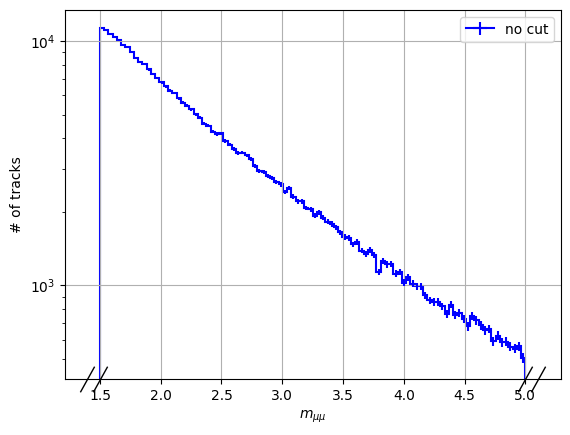

In [35]:
hMass_LS.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

In [14]:
print(hMass_OS.axes[0].centers.tolist())
print(hMass_OS.view().tolist())
print(hMass_LS.view().tolist())

[1.5174999999999998, 1.5525, 1.5875, 1.6225, 1.6574999999999998, 1.6925, 1.7275, 1.7625000000000002, 1.7975, 1.8325, 1.8675000000000002, 1.9025000000000003, 1.9375, 1.9725, 2.0075, 2.0425, 2.0775, 2.1125, 2.1475, 2.1825, 2.2175000000000002, 2.2525, 2.2875, 2.3225, 2.3575, 2.3925, 2.4275, 2.4625, 2.4975, 2.5324999999999998, 2.5675, 2.6025, 2.6375, 2.6725000000000003, 2.7075, 2.7424999999999997, 2.7775, 2.8125, 2.8475, 2.8825000000000003, 2.9175000000000004, 2.9524999999999997, 2.9875, 3.0225, 3.0575, 3.0925, 3.1275, 3.1625, 3.1975, 3.2325, 3.2675, 3.3025, 3.3375, 3.3725000000000005, 3.4074999999999998, 3.4425000000000003, 3.4775, 3.5125, 3.5475, 3.5824999999999996, 3.6174999999999997, 3.6525000000000003, 3.6875, 3.7224999999999997, 3.7575000000000003, 3.7925000000000004, 3.8275, 3.8625, 3.8975, 3.9324999999999997, 3.9675, 4.0024999999999995, 4.0375, 4.0725, 4.1075, 4.1425, 4.1775, 4.2125, 4.2475000000000005, 4.2825, 4.3175, 4.352499999999999, 4.3875, 4.422499999999999, 4.4575, 4.4925000

In [15]:
print(dir(vector.backends.awkward.MomentumArray4D))

['E', 'E2', 'Et', 'Et2', 'GenericClass', 'M', 'M2', 'Mask', 'Mt', 'Mt2', 'ProjectionClass2D', 'ProjectionClass3D', 'ProjectionClass4D', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array__', '__array_function__', '__array_ufunc__', '__arrow_array__', '__bool__', '__bytes__', '__cast_cpp__', '__class__', '__class_getitem__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__'